In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import sklearn.svm


Bad key "text.kerning_factor" on line 4 in
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/d

## Create data:

[A, X, B, Y, C, C*, D]

In [32]:
## Create data

n_total = 10000
n_freq = 7
ratio_train = 0.8
n_train = int(ratio_train * n_total)
n_test = n_total - n_train
ratio_exp, ratio_unexp = 0.5, 0.5
ratio_control = 0
ratio_exp, ratio_unexp = ratio_exp / (ratio_exp + ratio_unexp + ratio_control),  ratio_unexp / (ratio_exp + ratio_unexp + ratio_control)
assert ratio_exp + ratio_unexp + ratio_control == 1

n_double = 1  # in between stimuli
n_input_times = 2

n_times = 4 + 3 * n_double

if n_double == 0:
    list_freq_input = [r'$A_1$', r'$A_2$', r'$B_1$', r'$B_2$', r'$C_1$', r'$C_2$', r'$D$']
    list_freq_output = [r'$A_1$', r'$A_2$', r'$B_1$', r'$B_2$', r'$C_1$', r'$C_2$', r'$D$']
    n_freq_plot = n_freq
elif n_double == 1:
    list_freq_output = [r'$A_1$', r'$A_2$', r'$B_1$', r'$B_2$', r'$C_1$', r'$C_2$', r'$D$']
    list_freq_input = []
    for el in list_freq_output:
        list_freq_input.append(el)
        list_freq_input.append(el)
    n_freq_plot = n_freq * (n_double + 1)
    
def fill_func(start, end, fi, se, th, fo, label=None):
    all_seq[start:end, fi, 0:(1 + n_double)] = 1
    all_seq[start:end, se, (1 + n_double):(2 + 2 * n_double)] = 1
    all_seq[start:end, th, (2 + 2 * n_double):(3 + 3 * n_double)] = 1
    all_seq[start:end, fo, (3 + 3 * n_double)] = 1   
    all_labels[start:end] = label

In [33]:

all_seq = np.zeros((n_total, n_freq, n_times))
all_labels = np.zeros(n_total)
label_str = ['abcd', 'xyc*d', 'abc*d', 'xycd', 'abcc*d', 'xycc*d']

fill_func(0, int(0.5 * n_total * ratio_exp), 0, 2, 4, 6, label=1)
fill_func(int(0.5 * n_total * ratio_exp), int(n_total * ratio_exp), 1, 3, 5, 6, label=2)
fill_func(int(n_total * ratio_exp), 
          int(n_total * (ratio_exp + 0.5 * ratio_unexp)), 0, 2, 5, 6, label=3)
fill_func(int(n_total * (ratio_exp + 0.5 * ratio_unexp)), 
          int(n_total * (ratio_exp + ratio_unexp)), 1, 3, 4, 6, label=4)
fill_func(int(n_total * (ratio_exp + ratio_unexp)), 
          int(n_total * (ratio_exp + ratio_unexp + 0.5 * ratio_control)), 
          0, 2, np.array([4, 5]), 6, label=5)
fill_func(int(n_total * (ratio_exp + ratio_unexp + 0.5 * ratio_control)), 
          n_total, 1, 3, np.array([4, 5]), 6, label=6)

noise_std = 0.1
all_seq += noise_std * np.random.randn(n_total, n_freq, n_times)
# plt.imshow(all_seq[980, :, :])

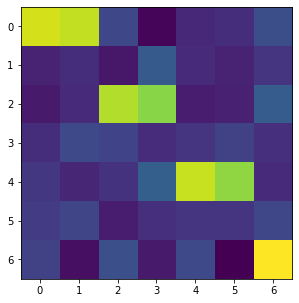

In [34]:
plt.imshow(all_seq[700, :, :])

In [35]:
shuffle_ind = np.random.choice(a=n_total, size=n_total, replace=False)
all_seq = all_seq[shuffle_ind, :, :]
train_seq = all_seq[:n_train, :, :]
test_seq = all_seq[n_train:, :, :]
all_labels = all_labels[shuffle_ind]
train_labels = all_labels[:n_train]
test_labels = all_labels[n_train:]

In [36]:
x_train = np.zeros((n_train, n_freq, n_input_times), dtype=np.float32)
y_train = np.zeros((n_train, n_freq), dtype=np.float32)  # hard code that only 1 time is output
x_test = np.zeros((n_test, n_freq, n_input_times), dtype=np.float32)
y_test = np.zeros((n_test, n_freq), dtype=np.float32)

for n_trial in range(n_train):
    start = np.random.randint(low=0, high=int(n_times - n_input_times))
    x_train[n_trial, :, :] = all_seq[n_trial, :, start:(start + n_input_times)]
    y_train[n_trial, :] = all_seq[n_trial, :, (start + n_input_times)]

for n_trial in range(n_test):
    start = np.random.randint(low=0, high=int(n_times - n_input_times))
    x_test[n_trial, :, :] = all_seq[n_trial + n_train, :, start:(start + n_input_times)]
    y_test[n_trial, :] = all_seq[n_trial + n_train, :, (start + n_input_times)]
    
x_train = x_train.reshape((n_train, -1))
x_test = x_test.reshape((n_test, -1))
n_input = x_train.shape[1]
n_output = y_train.shape[1]
y_train = y_train.reshape((n_train, -1))
y_test = y_test.reshape((n_test, -1))

In [37]:
y_train.shape

(8000, 7)

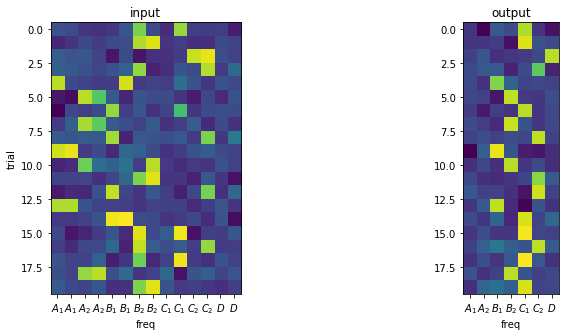

In [38]:
plt.rcParams['figure.figsize'] = (12, 5)

ax1 = plt.subplot(121)
trial_slice = slice(60, 80)
ax1.imshow(x_train[trial_slice, :].squeeze())
ax1.set_xlabel('freq'); ax1.set_ylabel('trial')
ax1.set_xticks([x for x in range(n_freq_plot)])
ax1.set_xticklabels(list_freq_input)
ax1.set_title('input')

ax2 = plt.subplot(122)
ax2.imshow(y_train[trial_slice, :].squeeze())
ax2.set_xlabel('freq');# ax2.set_ylabel('trial')
ax2.set_xticks([x for x in range(n_freq)])
ax2.set_xticklabels(list_freq_output)
ax2.set_title('output');

In [39]:
x_train, y_train, x_test, y_test = map(
    torch.tensor, (x_train, y_train, x_test, y_test))

## Train a model

In [40]:
n_hidden = 20
learning_rate = 0.1
bs = 200
n_epochs = 1000
check_conv = False
conv_rel_tol = 1e-6
l1_param = 1e-4

In [41]:
check_conv = False

In [42]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=n_test)

In [43]:
train_dl

In [44]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(n_input, n_hidden)
        self.lin2 = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = torch.sigmoid(self.lin1(x))
        x = self.lin2(x)
        return x

In [45]:
def eval_decoder(model_test, plot=False):
    n_trials_dec = 400
    x_train_decoder = np.zeros((n_trials_dec, n_input), dtype=np.float32)
    x_train_decoder[:int(0.5 * n_trials_dec), np.array([4, 9])] = 1
    x_train_decoder[int(0.5 * n_trials_dec):, np.array([6, 9])] = 1
    # x_train_decoder[:int(0.5 * n_trials_dec), np.array([4, 9])] = 1
    # x_train_decoder[int(0.5 * n_trials_dec):, np.array([4, 11])] = 1
    # x_train_decoder[:int(0.5 * n_trials_dec), 0:2] = 1
    # x_train_decoder[int(0.5 * n_trials_dec):, 2:4] = 1
    x_train_decoder += noise_std * np.random.randn(n_trials_dec, n_input)
    with torch.no_grad():
        w_train_decoder = torch.sigmoid(model_test.lin1(torch.tensor(x_train_decoder)))
        w_train_decoder = w_train_decoder.detach().numpy()
    y_train_decoder = np.zeros((n_trials_dec))
    y_train_decoder[:int(0.5 * n_trials_dec)] = 1

    decoder = sklearn.svm.LinearSVC()
    decoder.fit(X=w_train_decoder, y=y_train_decoder)
    
    decision = decoder.decision_function(w_train_decoder)
    if plot:
        plt.plot(decision)
    av_dec_1 = np.mean(decision[:int(0.5 * n_trials_dec)])
    av_dec_2 = np.mean(decision[int(0.5 * n_trials_dec):])
    
    return av_dec_1 - av_dec_2

In [46]:
# def loss_function
# loss_function = F.mse_loss

def loss_function(y_est, y_true, mod=None, reg_param=l1_param):
    loss = F.mse_loss(y_est, y_true)
#     print(loss)
    if mod is not None:
        params = [x for x in mod.parameters()]
        for i in range(len(params)):
            loss += reg_param * params[i].norm(p=1)
#         print(loss)
    return loss

In [47]:
model = MLP()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
prev_loss = 1
loss_prediction_list = []
loss_decoder_list = []
epoch_list = []
i_epoch = 0

In [48]:
for epoch in range(n_epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_function(pred, yb, mod=model, reg_param=5e-4)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    epoch_list.append(i_epoch)
    i_epoch += 1
    loss_prediction_list.append(loss_function(pred, yb).detach().numpy())
    loss_decoder_list.append(eval_decoder(model_test=model))
    if epoch % 20 == 1:
        print(f'epoch {epoch}, prediction loss: {loss_function(pred, yb)}, decoder loss: {eval_decoder(model_test=model)}')
        
    if check_conv:
        new_loss = loss_function(pred, yb).detach().numpy()
        diff = np.abs(new_loss - prev_loss) / (new_loss + prev_loss)
        if diff < conv_rel_tol:
            print(f'Converged at epoch {epoch},  loss: {loss_function(pred, yb)}')
            break
        prev_loss = new_loss
model.eval()
with torch.no_grad():
    print(loss_function(model(x_test), y_test))       

epoch 1, prediction loss: 0.12233926355838776, decoder loss: 1.9543154755115326
epoch 21, prediction loss: 0.084772489964962, decoder loss: 1.8418263314943975
epoch 41, prediction loss: 0.05660741403698921, decoder loss: 1.7001287766085404
epoch 61, prediction loss: 0.045685019344091415, decoder loss: 1.6213809350033048
epoch 81, prediction loss: 0.04155229032039642, decoder loss: 1.5314693682710185
epoch 101, prediction loss: 0.0393378920853138, decoder loss: 1.432896484537997
epoch 121, prediction loss: 0.03776194155216217, decoder loss: 1.3003308526909494
epoch 141, prediction loss: 0.036543551832437515, decoder loss: 1.1588636776302472
epoch 161, prediction loss: 0.035605691373348236, decoder loss: 0.9626795722969981
epoch 181, prediction loss: 0.034873686730861664, decoder loss: 0.8077705888243205
epoch 201, prediction loss: 0.03431430831551552, decoder loss: 0.7573748886015466
epoch 221, prediction loss: 0.03391703963279724, decoder loss: 0.6704762509185347
epoch 241, prediction 

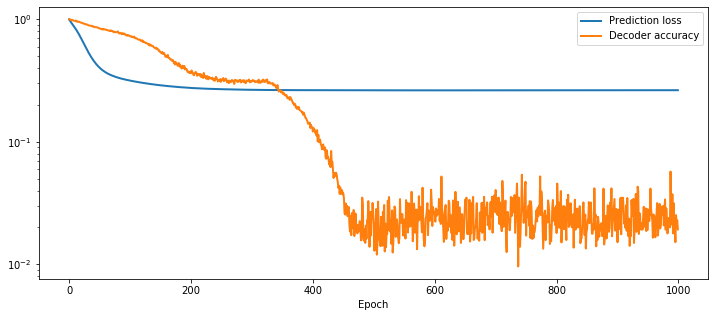

In [49]:
epoch_arr = np.array(epoch_list)
loss_prediction_arr = np.array(loss_prediction_list)
loss_decoder_arr = np.array(loss_decoder_list)

loss_prediction_arr = loss_prediction_arr / loss_prediction_arr[0]
loss_decoder_arr = loss_decoder_arr / loss_decoder_arr[0]

plt.plot(epoch_arr, loss_prediction_arr, label='Prediction loss', linewidth=2)
plt.plot(epoch_arr, loss_decoder_arr, label='Decoder accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend()

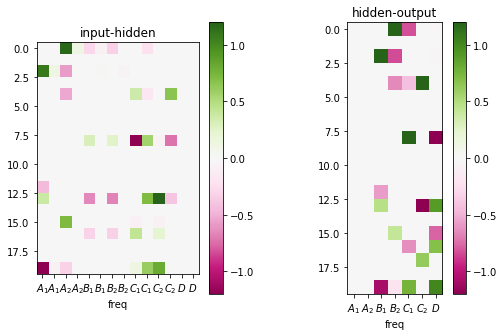

In [50]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 5), ncols=2)

left = ax0.imshow([x for x in model.parameters()][0].detach().numpy(),
                 vmin=-1.2, vmax=1.2, cmap='PiYG')
ax0.set_xlabel('freq');# ax2.set_ylabel('trial')
ax0.set_xticks([x for x in range(n_freq_plot)])
ax0.set_xticklabels(list_freq_input)
ax0.set_title('input-hidden');


right =ax1.imshow([x for x in model.parameters()][2].detach().numpy().transpose(), 
                  vmin=-1.2, vmax=1.2, cmap='PiYG')
ax1.set_xlabel('freq');# ax2.set_ylabel('trial')
ax1.set_xticks([x for x in range(n_freq)])
ax1.set_xticklabels(list_freq_output)
ax1.set_title('hidden-output');


fig.colorbar(left, ax=ax0)

fig.colorbar(right, ax=ax1)

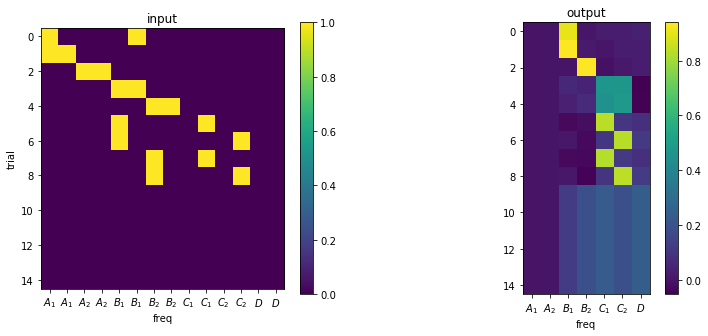

In [51]:
if n_double == 0:
    x_valid = torch.tensor(np.eye(7, dtype=np.float32))
elif n_double == 1:
    x_valid = np.zeros((15, 14), dtype=np.float32)
    x_valid[0, np.array([0, 5])] = 1
    x_valid[1, 0:2] = 1
    x_valid[2, 2:4] = 1
    x_valid[3, 4:6] = 1
    x_valid[4, 6:8] = 1
    x_valid[5, np.array([4, 9])] = 1
    x_valid[6, np.array([4, 11])] = 1
    x_valid[7, np.array([6, 9])] = 1
    x_valid[8, np.array([6, 11])] = 1
    x_valid[9, ]
    
    
    x_valid = torch.tensor(x_valid)
    
pred_x_valid = model(x_valid)
x_valid = x_valid.detach().numpy()
pred_x_valid = pred_x_valid.detach().numpy()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

left = ax1.imshow(x_valid)
ax1.set_xlabel('freq'); ax1.set_ylabel('trial')
ax1.set_xticks([x for x in range(n_freq_plot)])
ax1.set_xticklabels(list_freq_input)
ax1.set_title('input')

right = ax2.imshow(pred_x_valid)
ax2.set_xlabel('freq');# ax2.set_ylabel('trial')
ax2.set_xticks([x for x in range(n_freq)])
ax2.set_xticklabels(list_freq_output)
ax2.set_title('output');

fig.colorbar(left, ax=ax1)

fig.colorbar(right, ax=ax2)

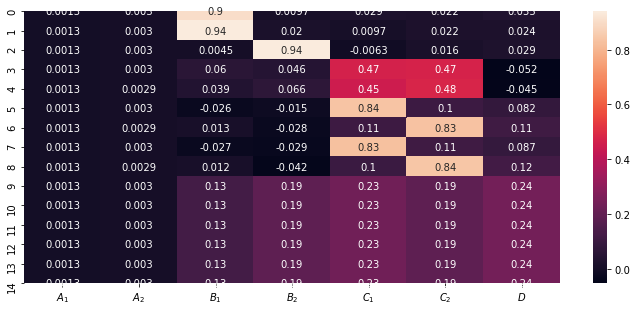

In [52]:
sns.heatmap(pred_x_valid, annot=True, xticklabels=list_freq_output)

## Decode

1) Make data with `x_decoder_train = torch.sigmoid(model.lin1(x_test[ 80% ])0`, `y_decoder_train = 1_{expected}` and test data

2) train decoder with sklearn SVM

3) assess performance on test data (or just train)

4) should do though... information is right there

In [45]:
eval_decoder(model_test=model)

0.2721622610136913


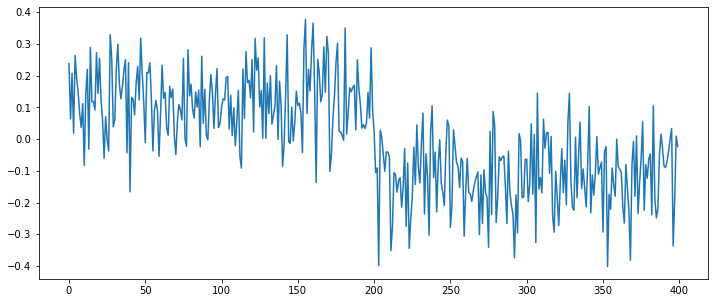